In [1]:
import sys
import json
from glob import glob
from os.path import basename
from multiprocessing import Queue, Pool, Manager
from functools import partial
from imp import reload

import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr
from statsmodels.stats.weightstats import CompareMeans, DescrStatsW
from sklearn.metrics import mean_squared_error as ms_err

import framework ; framework = reload(framework) ; from framework import *
import dsp ; dsp = reload(dsp) ; from dsp import *
import plotting ; plotting = reload(plotting) ; from plotting import *
%matplotlib inline

## Generate DataFrames from file names

In [2]:
dir_noises = 'data/test_noises/'

def parse_cfbw(filename):
    beg, end, d = filename.replace('.wav', '').split('--')
    cf1, bw1 = [int(x) for x in beg.split('-')]
    cf2, bw2 = [int(x) for x in end.split('-')]
    return [cf1, bw1, cf2, bw2, d]

def make_df_from_filenames():
    rows = []
    for w in glob(dir_noises + '*.wav'):
        bn = basename(w)
        rows.append([bn] + parse_cfbw(bn))
    df = pd.DataFrame(rows, columns=['fn', 'cf1', 'bw1', 'cf2', 'bw2', 'dir'])
    df_files = df.iloc[:, 0:1]
    df_data = df.iloc[:, 1:]
    return df_files, df_data

In [3]:
noise_files, noise_data_orig = make_df_from_filenames()

## Evaluate the method using noises as input

In [4]:
def get_split_freqs_glitch_fix(num_bands):  # FIXME glitch in low-frequency bands
    if num_bands > 12:  
        return get_split_freqs(num_bands)[2:], num_bands - 2
    else:
        return get_split_freqs(num_bands), num_bands

def cmp_to_str(x1, x2):
    if x1 < x2:
        return 'up'
    elif x1 > x2:
        return 'down'
    else:
        return 'still'
    

def eval_worker(q, num_bands_list, fn):
    rows = []
    for num_bands in num_bands_list:
        msa = MultibandAnalysis(MonoSound.from_file(dir_noises + fn))
        msa.bands_split, nbands = get_split_freqs_glitch_fix(num_bands)  # FIXME
        m = Movement(msa)
        row = [fn, int(nbands)]
        row += list(m.report.loc['Band Centroid', :])
        row += list(m.report.loc['Cumulative Peak Values', :])
        row += [json.dumps([ms_err(b.env, b.render_bpf()) for b in msa.bands])]
        row += [json.dumps(m.report_data.tolist())]
        rows.append(row)
    q.put(rows, True)

    
def method_eval(num_threads=8, num_bands_list=[2, 4, 6, 8, 10, 12, 16, 18, 20, 22]):
    files_total = len(noise_files)
    columns=['fn', 'numbands', 'cbeg', 'cend', 'cpvbeg', 'cpvend',
             'mse_raw', 'movement_raw']
    pool = Pool(num_threads)
    res_q = Manager().Queue(maxsize=num_threads)
    
#     s1 = set(noise_files['fn'])
#     s2 = set(pd.read_csv('noise_data_calc-bkp.csv', sep=';')['fn'])
#     files = list(s1.symmetric_difference(s2))
#     files_total = len(files)
#     pool.map_async(partial(eval_worker, res_q, num_bands_list), files)

    pool.map_async(partial(eval_worker, res_q, num_bands_list), noise_files['fn'])
    count = 0
    try:
        with open('noise_data_calc.csv', 'w') as f:
            f.write(';'.join(columns))
            f.write('\n')
            while count < files_total: 
                for res in res_q.get(True, 30):
                    f.write(';'.join([str(c) for c in res]))
                    f.write('\n')
                count += 1
                sys.stdout.write('{} / {}\r'.format(count, files_total))
                sys.stdout.flush()
    finally:
        print('\nDone')

In [ ]:
# method_eval()

In [16]:
def import_data(csv_file='noise_data_calc.csv', sep=';'):
    df = pd.read_csv(csv_file, sep=sep)
    string_enc = df['fn'].str.replace('.wav', '').str.split('--')
    df['cabsdiff'] = (df['cend'] - df['cbeg']).abs()
    df['cf1'] = string_enc.str.get(0).str.split('-').str.get(0).apply(pd.to_numeric)
    df['bw1'] = string_enc.str.get(0).str.split('-').str.get(1).apply(pd.to_numeric)
    df['cf2'] = string_enc.str.get(1).str.split('-').str.get(0).apply(pd.to_numeric)
    df['bw2'] = string_enc.str.get(1).str.split('-').str.get(1).apply(pd.to_numeric)
    df['dirorig'] = string_enc.str.get(2)
    df['dirpred'] = df.apply(lambda x: cmp_to_str(x['cbeg'], x['cend']), axis=1)
    df['correct'] = df['dirorig'] == df['dirpred']
    df['cfabsdiff'] = (df.cf1 - df.cf2).abs()
    df['bwabsdiff'] = (df.bw1 - df.bw2).abs()
    df['cpvabsdiff'] = (df.cpvbeg - df.cpvend).abs()
    df['rsmse'] = [np.sqrt(np.sum(json.loads(rse))) for rse in df['mse_raw']]

    return df

## Read data

In [45]:
# noise_data_calc = import_data()
# noise_data_calc.to_csv('noise_data_calc-cached.csv', sep=';')
noise_data_calc = pd.read_csv('noise_data_calc-cached.csv', sep=';', index_col=0)
noise_data_calc = noise_data_calc.query('dirorig != "still"')

In [46]:
noise_data_calc.describe()

,numbands,cbeg,cend,cpvbeg,cpvend,cabsdiff,cf1,bw1,cf2,bw2,cfabsdiff,bwabsdiff,cpvabsdiff,rsmse
count,361660.000000,361660.000000,361660.000000,361660.000000,361660.000000,361660.000000,361660.000000,361660.000000,361660.000000,361660.000000,361660.000000,361660.000000,3.616600e+05,361660.000000
mean,11.000000,8.360413,8.961884,0.636129,0.323252,0.677096,9247.517005,9377.430764,10751.074600,5460.239368,2374.730354,5328.221755,3.552564e-01,0.024809
std,5.744571,4.743224,5.067083,0.356774,0.201608,0.650367,3130.715994,4831.418356,3475.015292,3984.684490,1407.252874,3947.537649,2.771762e-01,0.009216
min,2.000000,0.017884,0.068729,0.004467,0.001510,0.000000,101.000000,202.000000,202.000000,202.000000,1.000000,0.000000,1.866010e-07,0.007419
25%,6.000000,4.349941,4.724872,0.358138,0.178768,0.171048,7171.000000,5455.000000,8282.000000,2222.000000,1111.000000,2021.000000,1.395896e-01,0.017576
50%,11.000000,8.372680,8.909726,0.574283,0.276613,0.499024,9393.000000,9495.000000,10807.000000,4647.000000,2323.000000,4445.000000,2.918574e-01,0.023021
75%,16.000000,12.226154,13.122659,0.861084,0.424415,0.991856,11312.000000,13131.000000,13232.000000,8081.000000,3536.000000,7878.000000,5.100089e-01,0.030572
max,20.000000,18.990681,18.993211,2.105013,1.693726,5.750067,18989.000000,20000.000000,19898.000000,19595.000000,4950.000000,19596.000000,1.762928e+00,0.074658


## Test sampling distribution of a mean C_diff

In [43]:
pred_correct = noise_data_calc.query('correct == True')
pred_error = noise_data_calc.query('correct == False')
pred_correct_cdiff = pred_correct['cend'] - pred_correct['cbeg']
pred_error_cdiff = pred_error['cend'] - pred_error['cbeg']

In [44]:
'Correct predictions: {}, wrong predictions: {} / {}% correct'.format(
    len(pred_correct), len(pred_error),
    round(len(pred_correct) / float(len(noise_data_calc)) * 100))

'Correct predictions: 279856, wrong predictions: 85474 / 77% correct'

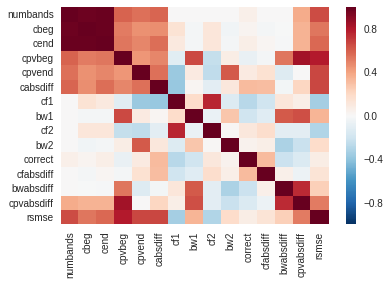

In [33]:
sns.heatmap(noise_data_calc.corr())

In [34]:
def calc_sm(x, sample_size=20, iters=15000):
    return pd.Series([x.abs().sample(sample_size).mean() for _ in range(iters)])

In [35]:
c_correct_sm = calc_sm(pred_correct_cdiff)
c_error_sm = calc_sm(pred_error_cdiff)

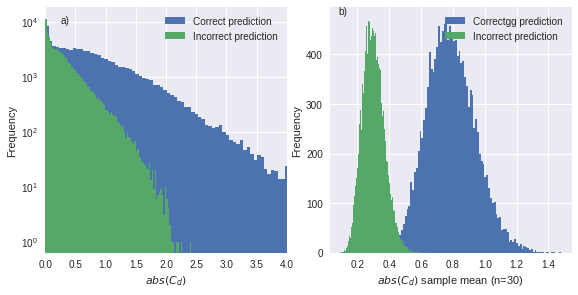

In [36]:
fig2, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4))
fig2.tight_layout(w_pad=1.5)

pred_correct_cdiff.sample(len(pred_error_cdiff)).abs().hist(bins=100, ax=ax1)
pred_error_cdiff.abs().hist(bins=100, ax=ax1)
ax1.set_xlim([0, 4])
ax1.set_yscale('log')
ax1.set_xlabel('$abs(C_d)$')
ax1.set_ylabel('Frequency')
ax1.legend(['Correct prediction', 'Incorrect prediction'])
ax1.annotate('a)', xy=(0.25, 9500))

# sns.distplot(c_correct_sm, rug=True, ax=ax2)
# sns.distplot(c_error_sm, rug=True, ax=ax2)
c_correct_sm.hist(bins=100, ax=ax2)
c_error_sm.hist(bins=100, ax=ax2)
ax2.set_xlabel('$abs(C_d)$ sample mean (n=30)')
ax2.set_ylabel('Frequency')
ax2.legend(['Correctgg prediction', 'Incorrect prediction'])
ax2.annotate('b)', xy=(0.0775, 480))

# fig2.savefig('2cdiff.pdf')

There is a slight positive relationship between the absolute centroid descriptor and the prediction correctness:

In [37]:
pearsonr(noise_data_calc.cabsdiff, noise_data_calc.correct)

(0.31927966900198013, 0.0)

In [38]:
pearsonr(noise_data_calc.cfabsdiff, noise_data_calc.correct)

(0.3172454274466241, 0.0)

## Test True-False count for each band

In [ ]:
def mbsa_quickplot(fn, num_bands, figsize=(4,4), to_fig=None):
    mbsa = MultibandAnalysis(MonoSound.from_file(dir_noises + fn))
    mbsa.bands_split = get_split_freqs_glitch_fix(num_bands)
    mov = Movement(mbsa)
    MultibandPlot(mbsa).plot(figsize=figsize, to_fig=to_fig)
    return mov.report

In [ ]:
def test_diff_bool_still_or_rises(x):
    s = np.sum(np.diff(x))
    return s == 0 or s == 1

filename_group = noise_data_calc.groupby('fn')
stable_group = filename_group.filter(
                    lambda x: test_diff_bool_still_or_rises(x.correct))
unstable_group = filename_group.filter(
                    lambda x: not test_diff_bool_still_or_rises(x.correct))

In [ ]:
df = pd.DataFrame(columns=['numbands', 'correct', 'count'])
for (b, c), count in unstable_group.groupby(['numbands', 'correct']).count()['fn'].iteritems():
    df.loc[len(df)] = [b, 'Correct' if c else 'Incorrect', count]
df.numbands = df.numbands.astype(np.int)

ax = sns.barplot(x='numbands', y='count', hue='correct', data=df)
ax.set_ylabel('Frequency')
ax.set_xlabel('Number of frequency bands')
ax.get_legend().set_title(None)
plt.gcf().savefig('3FalseTrueCount.pdf')

In [ ]:
noise_data_calc.corr()

In [ ]:
fig4, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4), sharey=True)
fig4.tight_layout(w_pad=1.5)

unstable_group.groupby('numbands').correct.agg(['mean', 'std']).plot(ax=ax1)
stable_group.groupby('numbands').correct.agg(['mean', 'std']).plot(ax=ax2)

ax1.set_ylim(0, 1)
ax1.set_ylabel('Prediction rate')
ax1.set_xlabel('Number of frequency bands')
ax1.annotate('a)', xy=(2.7, 0.84))

ax2.set_xlabel('Number of frequency bands')
ax2.annotate('b)', xy=(2.7, 0.84))

fig4.savefig('4PR.pdf')

In [ ]:
stable_group.describe()

In [ ]:
unstable_group.describe()

In [ ]:
unstable_group.fn.unique()

In [ ]:
tf = '8686-11717--10706-7273--up.wav'
t = unstable_group.query('fn == @tf')

In [ ]:
t

In [ ]:
mbsa_quickplot(tf, 6, to_fig='5aNoise.pdf')

In [ ]:
mbsa_quickplot(tf, 8, to_fig='5bNoise.pdf')

In [ ]:
len(noise_data_calc.query('correct == True'))

In [ ]:
len(noise_data_calc.query('correct == False'))